# Create database of Street Volume
This jupyter notebook is for creating the street volume aspect of the db for the SF Parking EDA. There are 3 data sources being:
1. Address Data(already in database)
3. Volume Data (shp)
4. street sweeping data (csv) from openData SF

The goal is to create a relational database so we can do some more exploratory analysis

# Street Volume Data
This data was provided in shapefile format by the SF Country Transportation Authority, and is actually just volume estimates. This all comes out of a model called SFCHAMP. To read more about SFCHAMP, follow this link. (https://www.sfcta.org/modeling-and-travel-forecasting)

It is in a coordinate system located in California, and must be converted into a global coordinate system to be mapped in folium. Actual mapping done in 'Explore Data' notebook.This will be just for creating a table that we can do statistcial analysis on. 

1. Read in the street volume data
2. Combine all forms of transortation into one total volume 
3. Link our street sweeping data with traffic volume data
4. Use sweeping data to find correct link id
5. Load street parking availability and combine with street volume 
6. Create new tables 'address_data', 'street_sweep_data', 'street_volume_data'
7. Save our shapefiles into a new processed form that we can use for mapping later. 


In [10]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import sqlite3
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

conn = sqlite3.connect('SF_Parking.db')
raw_folder = '/home/colin/Desktop/SF_Parking/data/raw/'
proc_folder = '/home/colin/Desktop/SF_Parking/data/processed/'

In [11]:
#function to return queries into DF
def result_query(querystring):
    resultdf = pd.read_sql(sql= querystring, con = conn)
    
    return resultdf 

In [12]:
streetvolume = gpd.read_file(raw_folder + '/street_volume/LOADALL_FINAL.shp')
streetvolume.crs = {'init' : 'epsg:2227'}
streetvolume = streetvolume.to_crs(epsg = 4326)
streetvolume = streetvolume[streetvolume['MTYPE'] == 'SF']
streetvolume.columns = streetvolume.columns.str.lower()

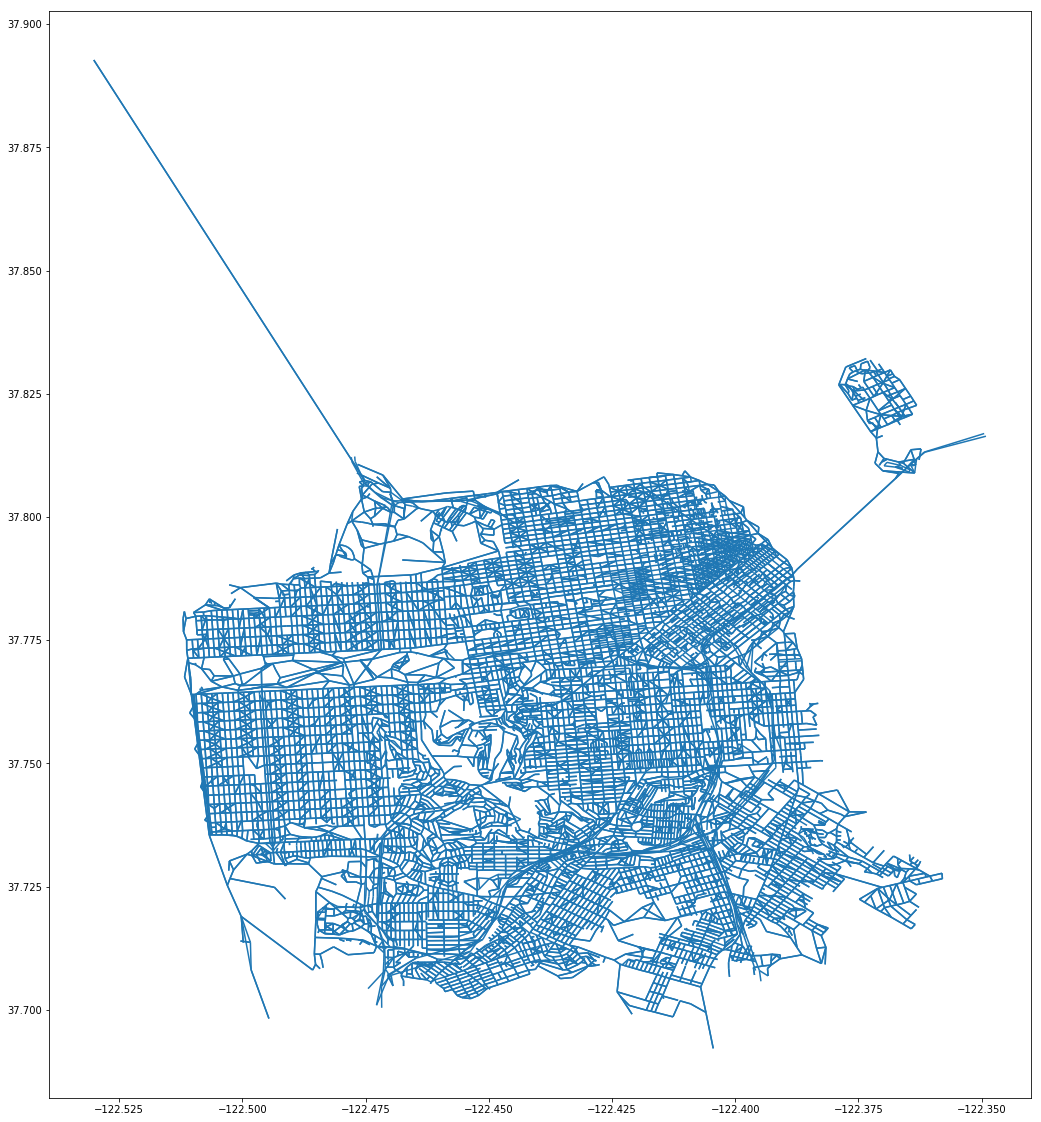

In [13]:
streetvolume.plot(figsize = (20,20))

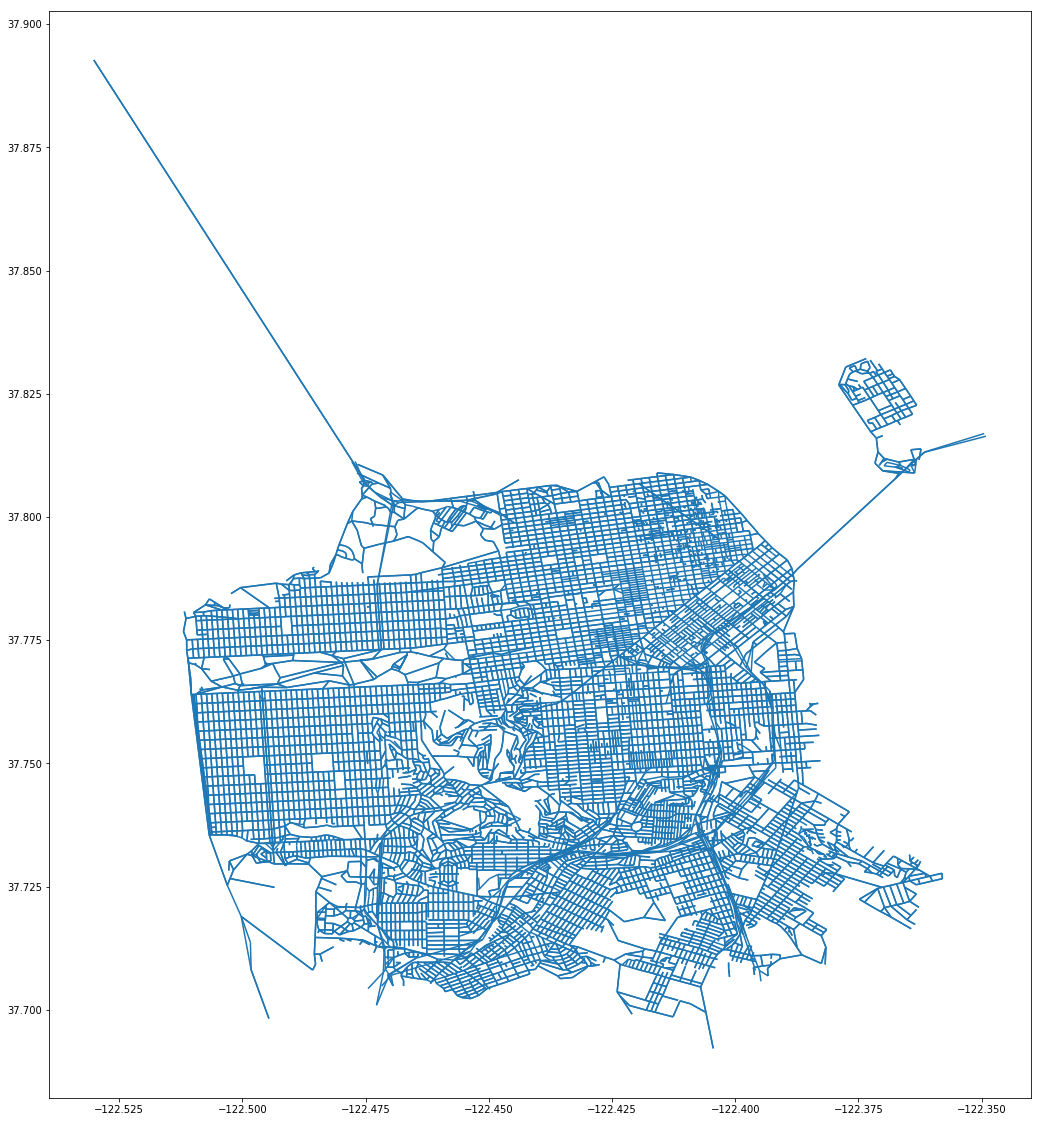

In [14]:
streetvolume[pd.isnull(streetvolume.streetname) == False].plot(figsize = (20,20))

In [15]:
streetvolume['distance'].sort_values( ascending = False)[:10]

18182    7.8968
55816    7.8967
52923    1.9800
51930    1.9800
57233    1.6845
56840    1.6837
56485    1.2000
56423    1.1600
54016    1.1400
36929    1.1400
Name: distance, dtype: float64

In [16]:
#Remove the outliers
streetvolume = streetvolume[(streetvolume['distance'] <= 7) & (pd.isnull(streetvolume.streetname) == False)]

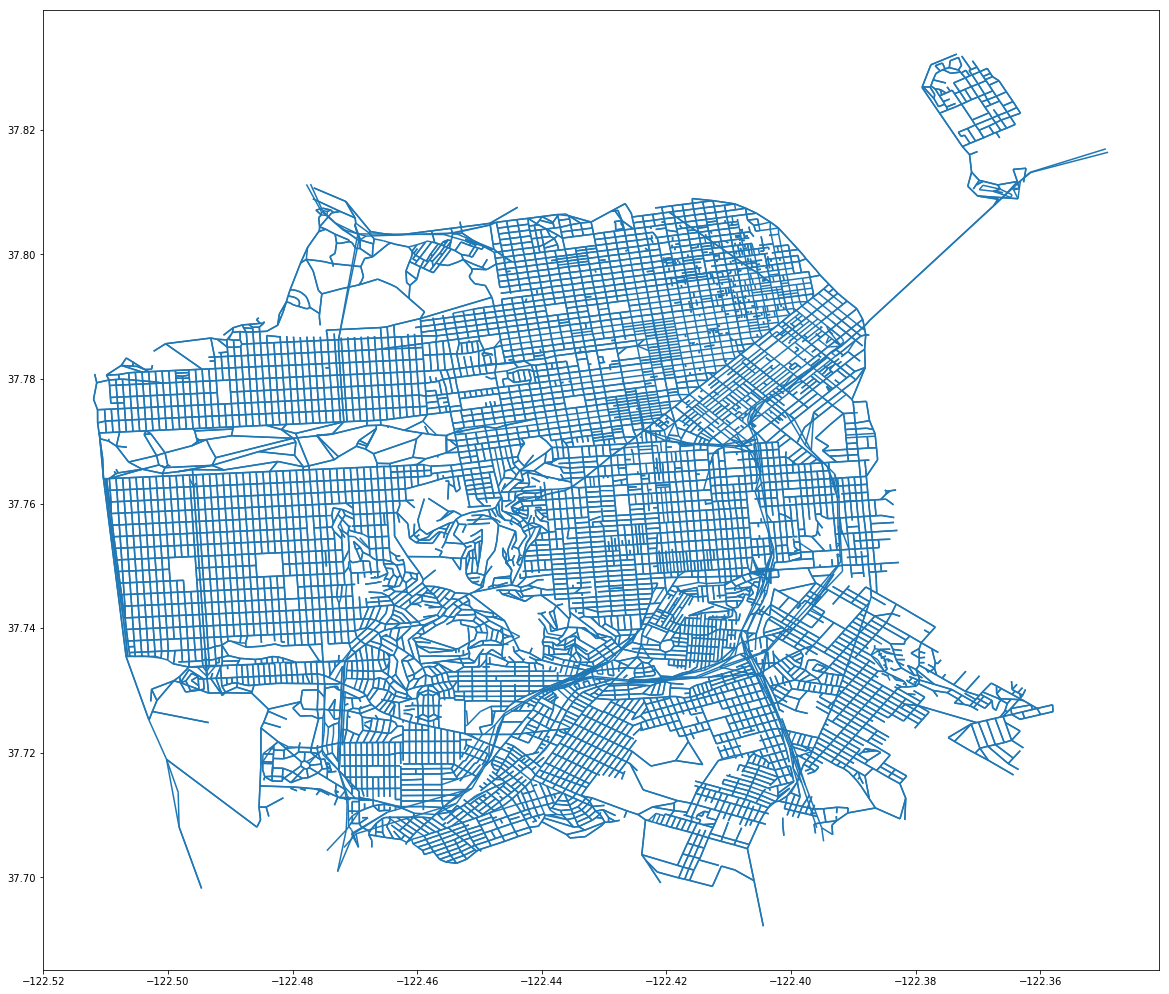

In [17]:
streetvolume.plot(figsize = (20,20))

In [18]:
#Lets create a function to map numbers with their full streetname 
replacements = ['[^0-9a-zA-Z\s]', '^0+']
streetnums = {'1':'ST', '2': 'ND', '3': 'RD', '4': 'TH', '5': 'TH', '6': 'TH', '7': 'TH', '8': 'TH', '9': 'TH', '0': 'TH'}
def replace_street(street):
    if isinstance(street, str):
        for rep in replacements:
            street = re.sub(rep, "", street)
    
    streetint = re.findall(r'\d+', str(street))
    if len(streetint) > 0 and int(streetint[0]) < 100:
        street = int(streetint[0])
        
        if street < 10:
            street = '0' + str(street) + str(streetnums[str(street)])
        else:
            street = str(street) + str(streetnums[str(street)[-1]])

        
    return street

streetvolume['streetname'] = streetvolume['streetname'].apply(replace_street)

In [19]:
times = ['am', 'pm', 'ev', 'ea']
columnlist = ['v_over_cea', 'distance', 'streetname', 'geometry', 'vvol_carea', 'vvol_trkea', 'vvol_busea', 'speed_ea', 'oneway', 'speed', 'bike_class', 'time_ea']
for i in np.arange(4):
    streetvolume['total_' + times[i]] = streetvolume['vvol_car' +times[i]] + streetvolume['vvol_trk' + times[i]] + streetvolume['vvol_bus' + times[i]]
    columnlist.append('total_' + times[i])

streetvolume = streetvolume[columnlist]

In [20]:
#Let's create a dataframe that uses the index as the lineid
streetvolume.reset_index(inplace = True)
streetvolume.rename(columns = {'index' : 'lineid'}, inplace = True)
streetvolume.to_file(proc_folder + '/final_streets/SF_Street_Data.shp')

In [21]:
streetvolume = gpd.read_file(proc_folder + '/final_streets/SF_Street_Data.shp')

In [22]:
streetvolume.head()

lineid  v_over_cea  distance          streetname  vvol_carea  vvol_trkea  \
0   15418         0.0    0.1532  HWY 101 NORTHBOUND  3405.10931   265.67899   
1   15502         0.0    0.1049               ALANA    57.16659     5.01155   
2   15504         0.0    0.1172              TUNNEL     0.00000     0.00000   
3   17596         0.0    0.7164             SKYLINE   423.91119     8.02989   
4   17673         0.0    0.1524       I280 S ONRAMP   632.02358    11.09846   

   vvol_busea  speed_ea  oneway  speed  bike_class  time_ea     total_am  \
0         0.0  59.96955       1     60           0  0.15328  17898.12590   
1         0.0  16.66667       0     30           0  0.37764    312.74319   
2         0.0  16.66667       0     30           0  0.42192      0.00000   
3         0.0  59.73132       0     60           3  0.71962   3632.46872   
4         0.0  23.06543       1     30           0  0.39644   3795.64821   

      total_pm     total_ev    total_ea  \
0  13928.34755  10671.88221  3670.78830   
1    114.65432    127.34847    62.17814   
2      0.00000      0.00000     0.00000   
3   5075.52099   3542.20130   431.94108   
4   3769.27644   3134.78179   643.12204   

                                            geometry  
0  LINESTRING (-122.3947633140051 37.705799300016...  
1  LINESTRING (-122.3960701555317 37.707089710661...  
2  LINESTRING (-122.4011409615126 37.706703815751...  
3  LINESTRING (-122.4946014034616 37.698238692712...  
4  LINESTRING (-122.4694172353115 37.704851953965...

# Street Sweeping Data
There will probably some interesting interactions with timing of street cleaning. Also, this has more data we can assign all addresses to  because it has block limits, so it will befaster to assign all addresses.This data comes from openDataSF and is in shapefile form. We will link the street ID from street sweeping to an ID in the streetvolume. We'll store information about when and how often they conduct street cleaning. 

In [23]:
streetsweeping = gpd.read_file(raw_folder + '/street_sweeping/Street_Sweeping.shp')

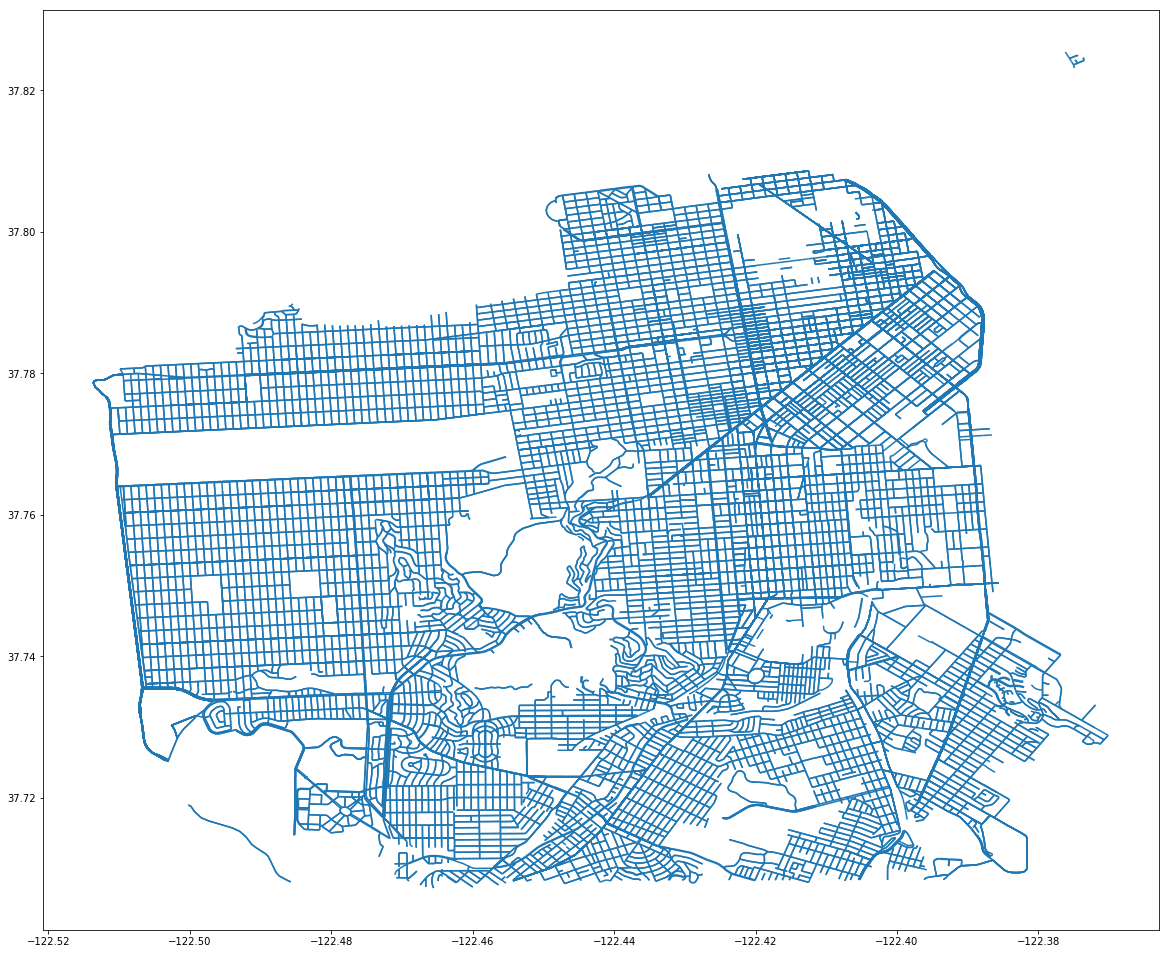

In [24]:
streetsweeping.plot(figsize = (20,20))

Looks like this is in a format where they can split out some records into two even though it could just be recorded as one. Maybe that is splitting it by shifts or drivers or something.  Let's try to fix that

In [25]:
# First let's create dummies for 'Y' and 'N'
streetsweeping['totalpermonth'] = 0
for i in np.arange(1,6):
    colname = 'week' + str(i) + 'ofmon'
    streetsweeping[colname] = streetsweeping[colname].apply(lambda x: 1 if x == 'Y' else 0 ) 
    streetsweeping['totalpermonth'] += streetsweeping[colname]
  

now lets sum up all the columns for each street link, day of the week, and time, then we can just remove all duplicates

In [26]:
streetsweeping.drop_duplicates(subset = ['cnn', 'blockside', 'weekday'])
df = streetsweeping.groupby(by = ['cnn', 'blockside', 'weekday'])['week1ofmon', 'week2ofmon', 'week3ofmon', 'week4ofmon', 'week5ofmon', 'totalpermonth'].sum()
streetsweeping.drop(columns = ['totalpermonth', 'week1ofmon', 'week2ofmon', 'week3ofmon', 'week4ofmon', 'week5ofmon'] , inplace = True)
streetsweeping = streetsweeping.merge(df, left_on = ['cnn', 'blockside', 'weekday'], right_on = ['cnn', 'blockside', 'weekday'])

Now lets try and pair each street segment with street volume link. We'll do this because street sweeping data had address limits, so we can easily join our addresses on them. 


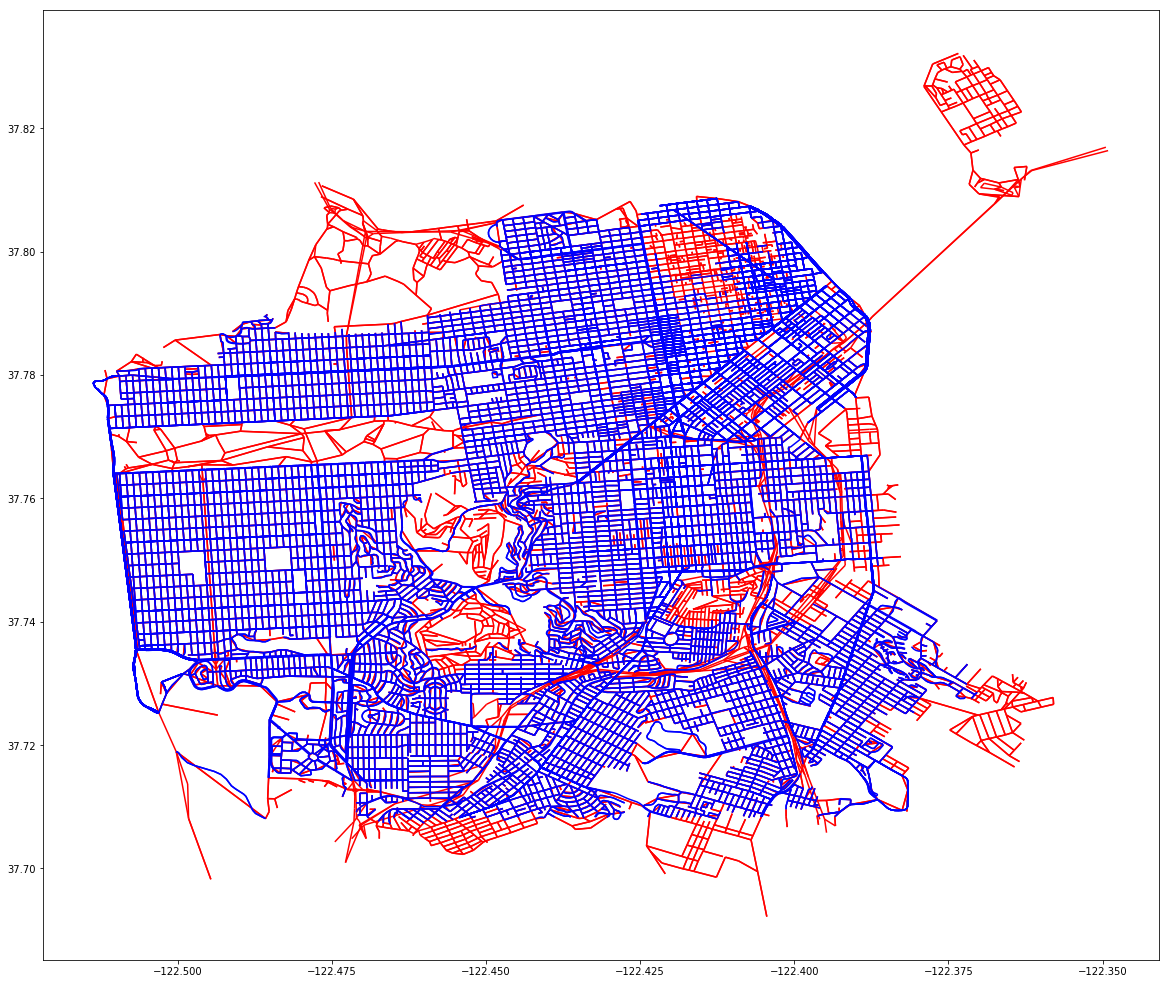

In [27]:
ax = streetvolume.plot(color = 'red', figsize = (20,20))
streetsweeping.plot(ax = ax, color = 'blue')

In [28]:
#remove suffix so we can pair with the street volume
#Some streets have names like 'AVENUE A' we dont want to strip out, only remove the last suffix if in the list
valid_suffix = ['ST', 'WY', 'DR', 'AV', 'LN', 'WAY', 'TER', 'PL', 'BLVD', 'AVE']
def return_street(streetname):
    if streetname.split(" ")[-1] in valid_suffix:
        return" ".join(str(streetname).split(" ")[:-1])
    
    return streetname

streetsweeping['streetname'] = streetsweeping['streetname'].apply(return_street)


In [29]:
#Lets try using a shapely join
from geopandas.tools import sjoin
streetvolume_j = streetvolume[['lineid', 'geometry', 'streetname', 'total_ea']]
streetsweeping = sjoin(streetsweeping, streetvolume_j, how='left')

In [30]:
streetsweeping[['streetname_left', 'streetname_right']]

streetname_left streetname_right
0       WEST POINT RD     MIDDLE POINT
0       WEST POINT RD     MIDDLE POINT
1            HARRISON             05TH
1            HARRISON             05TH
1            HARRISON             80TH
1            HARRISON           MERLIN
1            HARRISON           MERLIN
2            HARRISON             05TH
2            HARRISON             05TH
2            HARRISON             80TH
2            HARRISON           MERLIN
2            HARRISON           MERLIN
3            HARRISON             05TH
3            HARRISON             05TH
3            HARRISON             80TH
3            HARRISON           MERLIN
3            HARRISON           MERLIN
4            HARRISON             05TH
4            HARRISON             05TH
4            HARRISON             80TH
4            HARRISON           MERLIN
4            HARRISON           MERLIN
5            HARRISON             05TH
5            HARRISON             05TH
5            HARRISON             80TH
5            HARRISON           MERLIN
5            HARRISON           MERLIN
6            HARRISON         HARRISON
7            HARRISON         HARRISON
8            HARRISON         HARRISON
...               ...              ...
37051            08TH             16TH
37051            08TH             16TH
37051            08TH        WISCONSIN
37051            08TH        WISCONSIN
37052            08TH             16TH
37052            08TH             16TH
37052            08TH        WISCONSIN
37052            08TH        WISCONSIN
37053            09TH              NaN
37054            09TH              NaN
37055            09TH             09TH
37055            09TH             09TH
37055            09TH             LAKE
37055            09TH             LAKE
37055            09TH       CALIFORNIA
37055            09TH       CALIFORNIA
37056            09TH             09TH
37056            09TH             09TH
37056            09TH             LAKE
37056            09TH             LAKE
37056            09TH       CALIFORNIA
37056            09TH       CALIFORNIA
37057         MISSION              NaN
37058         MISSION              NaN
37059         MISSION              NaN
37060         MISSION              NaN
37061         MISSION              NaN
37062         MISSION              NaN
37063         MISSION              NaN
37064         MISSION              NaN

[103655 rows x 2 columns]

Looks like it is joing on all intersections, lets remove those. Then we'll have to try and associate each street by distance for any that didn't match. 

In [31]:
tqdm.pandas()
streetsweeping.drop(columns = 'index_right', inplace = True)
unfound = streetsweeping[pd.isnull(streetsweeping.lineid) | (streetsweeping.streetname_left != streetsweeping.streetname_right)]
streetsweeping= streetsweeping[streetsweeping.streetname_left == streetsweeping.streetname_right]
streetsweeping.drop(columns = ['streetname_right'], inplace = True)
streetsweeping.rename(columns = {'streetname_left':'streetname'}, inplace = True)
unfound.rename(columns = {'streetname_left':'streetname'}, inplace = True)
unfound.drop(columns = ['streetname_right'], inplace = True)
subset = [column for column in streetsweeping.columns if column not in ['geometry', 'lineid']]

In [32]:

streetsweeping.drop_duplicates(subset = subset, inplace = True)

In [33]:
unfound_cnn = unfound[['cnn', 'geometry', 'streetname']]
unfound_cnn.drop_duplicates(subset =['cnn'], inplace = True)

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
#Function to look for closest linestring
#Filter on same streetname, if none found then search all streets
#cnn is effectively the street link if for street cleaning, so we only need to look up that and then join it with all others. 
def find_closest_segment(LineString, street):
    streetdf = streetvolume[streetvolume['streetname'] == street]
    if streetdf.shape[0] == 0:
        streetdf = streetvolume
    streetdf['distance'] = streetdf['geometry'].apply(lambda x: LineString.distance(x))
    streetdf.sort_values(by = 'distance', ascending = True, inplace = True)
    return streetdf['lineid'].iloc[0]

tqdm.pandas()
unfound.drop(columns = 'lineid', inplace = True)
unfound_cnn['lineid'] = unfound_cnn.progress_apply(lambda x: find_closest_segment(x['geometry'], x['streetname']), axis = 1)
unfound_cnn = unfound_cnn[['cnn', 'lineid']]
df = unfound.merge(unfound_cnn, left_on = 'cnn', right_on = 'cnn')

streetsweeping = streetsweeping.append(df)

  0%|          | 2/9683 [00:00<15:11, 10.62it/s]/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
 26%|██▌       | 2515/9683 [09:36<24:54,  4.80it/s]

KeyboardInterrupt: 

In [ ]:
#Save it as a new file, and store in SQLite. SQL doesn't like a geometry columns 
streetsweeping.to_file(proc_folder + '/final_sweeping.shp')
sqldf_sweep = streetsweeping.drop(columns = ['geometry', 'geometry'])
#sqldf_vol = streetvolume.drop(columns = 'geometry')
sqldf_sweep.to_sql('street_sweep_data', con = conn, if_exists = 'replace')
#sqldf_vol.to_sql('streetvolume', con = conn, if_exists = 'replace')

# Pair addresses with a street volume id
We can merge all addresses on their address numbers with the street cleaning id, then we can assign it to a street volume. This will be much faster than trying to pair all addresses directly with the street volume, when we can just merge on certain criteria of the street cleaning. 

In [ ]:
streetsweeping = gpd.read_file(proc_folder + '/final_sweeping.shp')
gs = streetsweeping
addresses = result_query('Select * from address_data')
streetsweeping['corridor'] = streetsweeping['corridor'].apply(lambda x: x.upper())
addresses['blocknum'] = addresses['number'].apply(lambda x: math.floor(int(x) / 100))
streetsweeping['blocknum'] = streetsweeping['lf_fadd'].apply(lambda x: math.floor(int(x) / 100))
streetsweeping = streetsweeping[['corridor', 'blocknum', 'lineid']]



In [ ]:
addresses = addresses.merge(streetsweeping,  how = 'left', left_on = ['street', 'blocknum'], right_on = ['corridor', 'blocknum'])


In [ ]:
addresses.drop_duplicates(subset = ['address'], inplace = True)
unfound = addresses[pd.isnull(addresses.lineid)]

#we'll lok up all other addresses using coordinates, so drop those we couldn;t pair that don't have ny
unfound.dropna(subset = ['lat', 'lon' ], inplace = True)
addresses.dropna(subset = ['lineid'], inplace = True)

In [30]:
addresses.drop(columns = ['blocknum', 'index', 'corridor'], inplace = True)

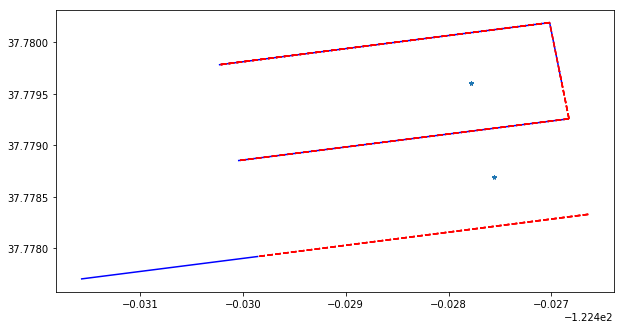

In [31]:
#Let's check this has all been working, we'll plot 100 addresses and all streets associated with them 
check = addresses[:100]
geometry = [Point(xy) for xy in zip(check.lon, check.lat)]
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(check, crs=crs, geometry=geometry)   


ax = streetvolume[streetvolume.lineid.isin(check.lineid)]['geometry'].plot( color = 'blue', figsize = (10,10))
gs[gs.lineid.isin(check.lineid)]['geometry'].plot(ax = ax, color = 'red', linestyle = '--')
gdf.plot( ax = ax, marker = "*", markersize = 8)


An example like this should be ok, where one line is attached by the opposie side, since the volume will most likely be the same in most circumstances. 

In [32]:


geometry = [Point(xy) for xy in zip(unfound.lon, unfound.lat)]
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(unfound, crs=crs, geometry=geometry)   

In [33]:
addresses = addresses[['lon', 'lat', 'number', 'street', 'address', 'streetname', 'nhood', 'lineid']]

In [34]:
tqdm.pandas()
gdf['lineid'] = gdf.progress_apply(lambda x: find_closest_segment(x['geometry'], x['street']), axis = 1)

addresses = addresses.append(gdf)

  1%|          | 294/42412 [00:41<1:40:31,  6.98it/s]/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
100%|██████████| 42412/42412 [1:44:33<00:00,  6.96it/s]  
/home/colin/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 

In [35]:
addresses = addresses.append(gdf)

/home/colin/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [36]:
addresses = addresses[['address', 'lat', 'lon', 'lineid', 'nhood', 'number', 'street', 'streetname']]

In [37]:
addresses.to_sql('address_data', conn, if_exists = 'replace')

# Street Parking Availability Data
This came from an online source, and is a shapefile. We'll do a similar join, and store the final result in sql and our shapefile. 

In [66]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.figure(figsize = (20,20))
tqdm.pandas()
%matplotlib inline
streetvolume = gpd.read_file(proc_folder + '/final_streets/SF_Street_Data.shp')
spaces = gpd.read_file('/home/colin/Desktop/Parking_Project/data/raw/SFpark_OnStreetParkingCensus_201404/Sfpark_OnStreetParkingCensus_201404/Sfpark_OnStreetParkingCensus_201404.shp')
spaces.crs = {'init': 'epsg:2227'}
spaces = spaces.to_crs(epsg =4326)

In [67]:
spaces = spaces[spaces.PRKNG_SPLY < 1000]
spaces.sort_values(by = 'PRKNG_SPLY', ascending = False, inplace = True)
spaces = spaces[['geometry', 'PRKNG_SPLY', 'ST_NAME']]
spaces.rename(columns = {'PRKNG_SPLY':'park_supply'}, inplace = True)
from geopandas.tools import sjoin
total_join = sjoin(streetvolume, spaces, how= 'left')

/home/colin/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [68]:
total_join

lineid  v_over_cea  distance          streetname   vvol_carea  \
0       15418         0.0   0.15320  HWY 101 NORTHBOUND   3405.10931   
1       15502         0.0   0.10490               ALANA     57.16659   
2       15504         0.0   0.11720              TUNNEL      0.00000   
3       17596         0.0   0.71640             SKYLINE    423.91119   
4       17673         0.0   0.15240       I280 S ONRAMP    632.02358   
5       17674         0.0   0.20770      JUNIPERO SERRA    172.51489   
6       17676         0.0   0.02440            SAN JOSE    224.16459   
7       17699         0.0   0.07833              DELONG      0.54688   
8       17700         0.0   0.06960             DE LONG      1.70313   
9       17703         0.0   0.07833              DELONG      0.97099   
10      17725         0.0   0.04870            BAYSHORE    218.64442   
11      17726         0.0   0.12452              GENEVA     78.80461   
12      17727         0.0   0.37583            BAYSHORE    248.21288   
13      17732         0.0   0.53237            BAYSHORE    117.80672   
14      17781         0.0   0.72040                80TH  10852.53257   
15      22809         0.0   0.28650              CARTER     21.01786   
16      27435         0.0   0.26000           JAMESTOWN      3.56806   
17      27436         0.0   0.26000       HUNTERS POINT      1.43869   
18      27437         0.0   0.05000           JAMESTOWN      0.00000   
19      27438         0.0   0.07000           JAMESTOWN      0.32123   
20      27439         0.0   0.11000              GIANTS      2.43997   
21      27440         0.0   0.07000            INGERSON      0.00570   
21      27440         0.0   0.07000            INGERSON      0.00570   
22      27441         0.0   0.25620              GIANTS      0.87500   
23      27442         0.0   0.07000              GILROY      0.00000   
24      27443         0.0   0.03000              GILROY      0.00000   
25      27444         0.0   0.08000             IGNACIO      0.00000   
25      27444         0.0   0.08000             IGNACIO      0.00000   
26      27445         0.0   0.03000             DONAHUE      0.00000   
26      27445         0.0   0.03000             DONAHUE      0.00000   
...       ...         ...       ...                 ...          ...   
26767   57858         0.0   0.12440             ORIENTE      0.00000   
26768   57859         0.0   0.12378           RIO VERDE      3.15179   
26769   57860         0.0   0.12797           RIO VERDE      0.65625   
26770   57861         0.0   0.05442             OTTILIA      0.00000   
26771   57862         0.0   0.11972            SCHWERIN    117.27679   
26772   57863         0.0   0.12120            SCHWERIN    123.77902   
26773   57864         0.0   0.05387             OTTILIA      0.00000   
26774   57865         0.0   0.13645           RIO VERDE      0.65625   
26775   57866         0.0   0.12797           RIO VERDE      3.15179   
26776   57867         0.0   0.05431           PARTRIDGE      0.00000   
26777   57868         0.0   0.01677            SCHWERIN    123.77902   
26778   57869         0.0   0.12120            SCHWERIN    117.27679   
26779   57870         0.0   0.05579           PARTRIDGE      0.00000   
26780   57871         0.0   0.12311             ACCACIA      0.00000   
26781   57872         0.0   0.05442             OTTILIA      0.00000   
26782   57873         0.0   0.12640             ACCACIA      0.00000   
26783   57874         0.0   0.05061             OTTILIA      0.00000   
26784   57875         0.0   0.13858             ACCACIA      0.00000   
26785   57876         0.0   0.05431           PARTRIDGE      0.00000   
26786   57877         0.0   0.12640             ACCACIA      0.00000   
26787   57878         0.0   0.05210           PARTRIDGE      0.00000   
26788   57879         0.0   0.12294             ORIENTE      0.00000   
26789   57880         0.0   0.05387             OTTILIA      0.00000   
26790   57881         0.0   0.05061            

In [69]:
#replace not found with a zero, drop duplciates 
total_join ['park_supply']= total_join.apply(lambda x: 0 if x['streetname'] != x['ST_NAME'] else x['park_supply'], axis = 1)

In [70]:
total_join

lineid  v_over_cea  distance          streetname   vvol_carea  \
0       15418         0.0   0.15320  HWY 101 NORTHBOUND   3405.10931   
1       15502         0.0   0.10490               ALANA     57.16659   
2       15504         0.0   0.11720              TUNNEL      0.00000   
3       17596         0.0   0.71640             SKYLINE    423.91119   
4       17673         0.0   0.15240       I280 S ONRAMP    632.02358   
5       17674         0.0   0.20770      JUNIPERO SERRA    172.51489   
6       17676         0.0   0.02440            SAN JOSE    224.16459   
7       17699         0.0   0.07833              DELONG      0.54688   
8       17700         0.0   0.06960             DE LONG      1.70313   
9       17703         0.0   0.07833              DELONG      0.97099   
10      17725         0.0   0.04870            BAYSHORE    218.64442   
11      17726         0.0   0.12452              GENEVA     78.80461   
12      17727         0.0   0.37583            BAYSHORE    248.21288   
13      17732         0.0   0.53237            BAYSHORE    117.80672   
14      17781         0.0   0.72040                80TH  10852.53257   
15      22809         0.0   0.28650              CARTER     21.01786   
16      27435         0.0   0.26000           JAMESTOWN      3.56806   
17      27436         0.0   0.26000       HUNTERS POINT      1.43869   
18      27437         0.0   0.05000           JAMESTOWN      0.00000   
19      27438         0.0   0.07000           JAMESTOWN      0.32123   
20      27439         0.0   0.11000              GIANTS      2.43997   
21      27440         0.0   0.07000            INGERSON      0.00570   
21      27440         0.0   0.07000            INGERSON      0.00570   
22      27441         0.0   0.25620              GIANTS      0.87500   
23      27442         0.0   0.07000              GILROY      0.00000   
24      27443         0.0   0.03000              GILROY      0.00000   
25      27444         0.0   0.08000             IGNACIO      0.00000   
25      27444         0.0   0.08000             IGNACIO      0.00000   
26      27445         0.0   0.03000             DONAHUE      0.00000   
26      27445         0.0   0.03000             DONAHUE      0.00000   
...       ...         ...       ...                 ...          ...   
26767   57858         0.0   0.12440             ORIENTE      0.00000   
26768   57859         0.0   0.12378           RIO VERDE      3.15179   
26769   57860         0.0   0.12797           RIO VERDE      0.65625   
26770   57861         0.0   0.05442             OTTILIA      0.00000   
26771   57862         0.0   0.11972            SCHWERIN    117.27679   
26772   57863         0.0   0.12120            SCHWERIN    123.77902   
26773   57864         0.0   0.05387             OTTILIA      0.00000   
26774   57865         0.0   0.13645           RIO VERDE      0.65625   
26775   57866         0.0   0.12797           RIO VERDE      3.15179   
26776   57867         0.0   0.05431           PARTRIDGE      0.00000   
26777   57868         0.0   0.01677            SCHWERIN    123.77902   
26778   57869         0.0   0.12120            SCHWERIN    117.27679   
26779   57870         0.0   0.05579           PARTRIDGE      0.00000   
26780   57871         0.0   0.12311             ACCACIA      0.00000   
26781   57872         0.0   0.05442             OTTILIA      0.00000   
26782   57873         0.0   0.12640             ACCACIA      0.00000   
26783   57874         0.0   0.05061             OTTILIA      0.00000   
26784   57875         0.0   0.13858             ACCACIA      0.00000   
26785   57876         0.0   0.05431           PARTRIDGE      0.00000   
26786   57877         0.0   0.12640             ACCACIA      0.00000   
26787   57878         0.0   0.05210           PARTRIDGE      0.00000   
26788   57879         0.0   0.12294             ORIENTE      0.00000   
26789   57880         0.0   0.05387             OTTILIA      0.00000   
26790   57881         0.0   0.05061            

In [71]:
total_join.sort_values(by = 'park_supply', inplace = True)
total_join.drop_duplicates(subset = ['lineid'], inplace = True)

In [72]:
total_join.to_file(proc_folder + '/final_streets/SF_Street_Data.shp')
total_join.drop(columns = ['index_right', 'geometry'], inplace = True)
total_join.to_sql('street_volume_data', conn, if_exists = 'replace')